<a href="https://colab.research.google.com/github/VitoZac96/Thesis_public/blob/main/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model: CNN replicata dal paper: Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline

https://arxiv.org/abs/1611.06455 

Installare pacchetti per scaricare la timeseries dei prezzi dell'indice S&P500

In [ ]:
!pip install yfinance
!pip install yahoofinancials

In [84]:
import yfinance as yf
from yahoofinancials import YahooFinancials
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from keras.layers import Dropout
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping

Funzione per creare gli input: le features che saranno usate nella CNN sono gli "n_steps" ritorni passati. 

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Download the data, select only the closing price and compute the daily percentage change. 

In [202]:
spx = yf.download('^GSPC', 
                      start='2008-01-01',    #'2015-07-07'
                      end='2021-04-01', 
                      progress=False)
spx = spx["Adj Close"].pct_change()[1:]

Creare x e y

In [203]:
x, y = split_sequence(spx,2)

Encoding per il classifier: se il ritorno di domani > 0: valore 1; 0 viceversa.

In [204]:
encoded = []
for i in y:
  if i>0:
    encoded.append(1)
  else:
    encoded.append(0)

y_target = pd.DataFrame(encoded).to_numpy()

Train test split e one hot encoding per il classifier

In [205]:
x_train, x_test, y_train, y_test_val = train_test_split(x, y_target, test_size=0.30, random_state=1)

y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test_val, 2)

Normalizzazione replicata dal paper

In [206]:
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean)/(x_train_std)

In [207]:
x_test = (x_test - x_train_mean)/(x_train_std)    #### Perché non con media e std di se stesso?????

x_train = x_train.reshape(x_train.shape + (1,1,))
x_test = x_test.reshape(x_test.shape + (1,1,))

Modello replicato dal Paper

In [208]:
from keras.models import Sequential
model = Sequential()


In [209]:
x = keras.layers.Input(x_train.shape[1:])
drop_out = Dropout(0.2)(x)
conv1 = keras.layers.Conv2D(128, 8, 1, padding='same')(x) #
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation('relu')(conv1)

drop_out = Dropout(0.1)(conv1)
conv2 = keras.layers.Conv2D(256, 5, 1, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

drop_out = Dropout(0.1)(conv2)
conv3 = keras.layers.Conv2D(128, 3, 1, padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)

full = keras.layers.GlobalAveragePooling2D()(conv3)
out = keras.layers.Dense(2, activation='softmax')(full)


model = keras.models.Model(inputs=x, outputs=out)
  
optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor=0.5, patience=50, min_lr=0.0001)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 50)

history = model.fit(x_train, y_train,  epochs=200, verbose=1, validation_data=(x_test, y_test), callbacks = [reduce_lr,es])
#batch_size=batch_size,

#Print the testing results which has the lowest training loss.
log = pd.DataFrame(history.history)
#print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_accuracy'])

Epoch 1/200
73/73 [==============================] - 1s 9ms/step - loss: 0.8427 - accuracy: 0.4885 - val_loss: 0.6951 - val_accuracy: 0.4270
Epoch 2/200
73/73 [==============================] - 0s 7ms/step - loss: 0.7002 - accuracy: 0.5192 - val_loss: 0.6990 - val_accuracy: 0.4350
Epoch 3/200
73/73 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.5387 - val_loss: 0.6912 - val_accuracy: 0.5680
Epoch 4/200
73/73 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.5128 - val_loss: 0.6895 - val_accuracy: 0.5710
Epoch 5/200
73/73 [==============================] - 0s 6ms/step - loss: 0.6995 - accuracy: 0.5439 - val_loss: 0.6903 - val_accuracy: 0.5370
Epoch 6/200
73/73 [==============================] - 0s 6ms/step - loss: 0.7059 - accuracy: 0.5315 - val_loss: 0.6836 - val_accuracy: 0.5710
Epoch 7/200
73/73 [==============================] - 0s 6ms/step - loss: 0.6987 - accuracy: 0.5055 - val_loss: 0.6827 - val_accuracy: 0.5720
Epoch 8/200
7

In [210]:
max(history.history['val_accuracy'])

0.5789999961853027

In [211]:
model.evaluate(x_test,y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5590


[0.6913726925849915, 0.5590000152587891]

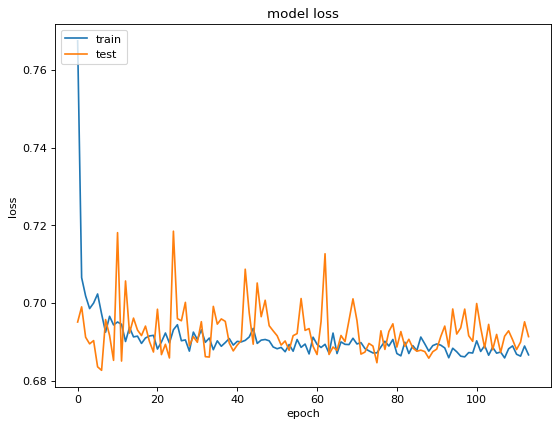

In [212]:
figure(figsize=(8, 6), dpi=80)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

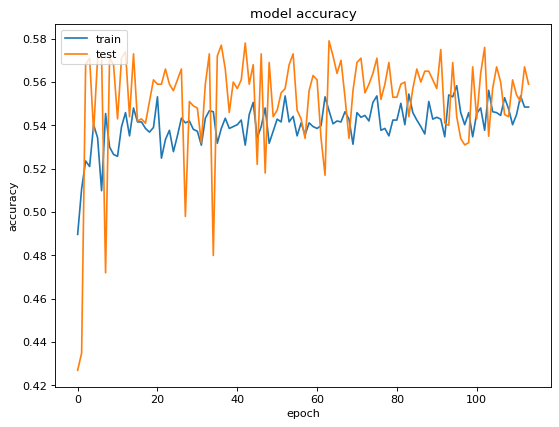

In [213]:
figure(figsize=(8, 6), dpi=80)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [214]:
predictions = model.predict(x_test)

In [215]:
np.column_stack((predictions.round(2),y_test))

array([[0.43, 0.57, 0.  , 1.  ],
       [0.38, 0.62, 0.  , 1.  ],
       [0.49, 0.51, 0.  , 1.  ],
       ...,
       [0.5 , 0.5 , 1.  , 0.  ],
       [0.5 , 0.5 , 0.  , 1.  ],
       [0.54, 0.46, 1.  , 0.  ]], dtype=float32)